In [243]:
from matplotlib.pyplot import scatter, title, xlabel, ylabel, figure, title, plot, legend, show, axvline
from pandas import read_csv
from numpy import asarray, min
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

In [244]:
# Read csv file 
packages_df = read_csv("datasets/Packstücke.csv", sep=";", header=0)  

# Show first ten rows of dataframe 
packages_df.head(10)

,Package No,Shipment No,Gross Weight (kg),Width (cm),Height (cm),Length (cm)
0,1007530-2011-03239,1000088,23,35,30,35
1,1007530-2011-03241,1000310,150,60,55,80
2,1007530-2011-03242,1000346,"0,5",14,15,19
3,1007530-2011-03243,1000456,"1,5",20,20,29
4,1007530-2011-03244,1000796,1,10,10,10
5,1007530-2011-03245,1000957,75,82,81,120
6,1007530-2011-03246,1000957,41,80,34,120
7,1007530-2011-03247,1001184,1.340,220,112,406
8,1007530-2011-03249,1001408,"0,5",20,20,29
9,1007530-2011-03250,1001563,5,45,35,45


In [245]:
# Show data types of columns
packages_df.dtypes

Package No           object
Shipment No           int64
Gross Weight (kg)    object
Width (cm)           object
Height (cm)           int64
Length (cm)           int64
dtype: object

Text(0, 0.5, 'Length (cm)')

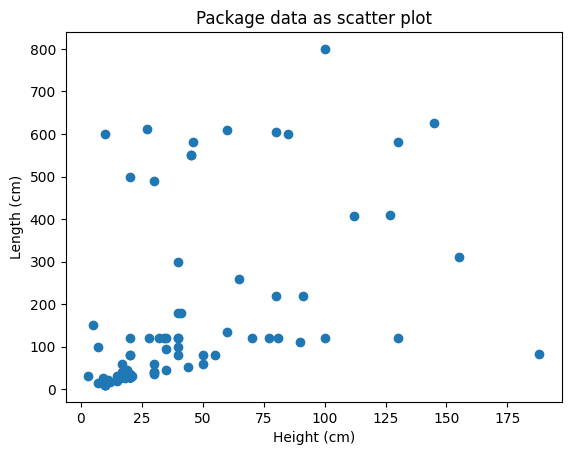

In [246]:
# Plot data as scatter  
scatter(packages_df["Height (cm)"].to_numpy(), packages_df["Length (cm)"].to_numpy())
title("Package data as scatter plot")
xlabel("Height (cm)")
ylabel("Length (cm)")

In [247]:
# Replace "," with "." (us standard)
packages_df["Gross Weight (kg)"] = packages_df.apply(lambda row: str(row["Gross Weight (kg)"]).replace(".", "").replace(",", "."), axis=1)
packages_df["Width (cm)"] = packages_df.apply(lambda row: str(row["Width (cm)"]).replace(".", "").replace(",", "."), axis=1)

# Convert to correct data type
packages_df[["Gross Weight (kg)", "Width (cm)"]] = packages_df[["Gross Weight (kg)", "Width (cm)"]].astype(float)
packages_df[["Height (cm)", "Length (cm)"]] = packages_df[["Height (cm)", "Length (cm)"]].astype(int)
packages_df[["Package No", "Shipment No"]] = packages_df[["Package No", "Shipment No"]].astype(str)

# Calculate volume of each row
packages_df["Volume (m³)"] = packages_df.apply(lambda row: row["Width (cm)"] * row["Height (cm)"] * row["Length (cm)"] / 1000000, axis=1)

# Drop not needed cols
x = packages_df.drop(["Package No", "Shipment No"], axis=1)

# Show first ten rows of dataframe 
x.head(10)

,Gross Weight (kg),Width (cm),Height (cm),Length (cm),Volume (m³)
0,23.0,35.0,30,35,0.036750
1,150.0,60.0,55,80,0.264000
2,0.5,14.0,15,19,0.003990
3,1.5,20.0,20,29,0.011600
4,1.0,10.0,10,10,0.001000
5,75.0,82.0,81,120,0.797040
6,41.0,80.0,34,120,0.326400
7,1340.0,220.0,112,406,10.003840
8,0.5,20.0,20,29,0.011600
9,5.0,45.0,35,45,0.070875


Text(0, 0.5, 'Volume (m³)')

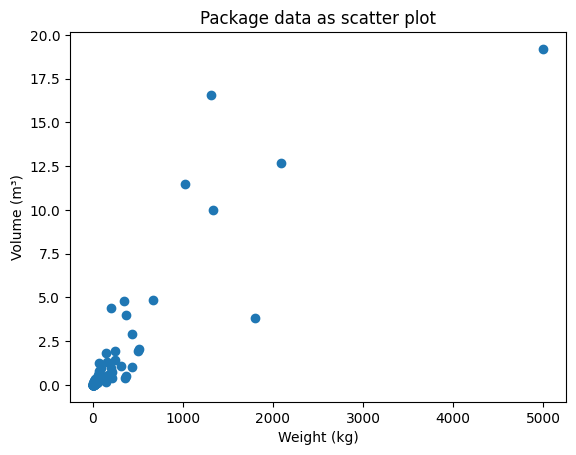

In [248]:
# Plot data as scatter  
scatter(x["Gross Weight (kg)"].to_numpy(), x["Volume (m³)"].to_numpy())
title("Package data as scatter plot")
xlabel("Weight (kg)")
ylabel("Volume (m³)")

Text(0, 0.5, 'Volume (m³)')

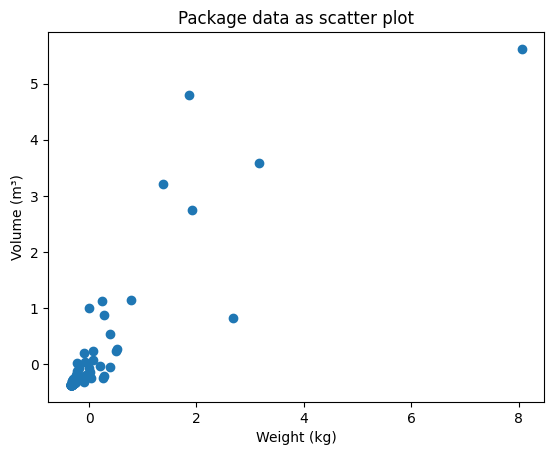

In [249]:
# Normalize data
scaler = preprocessing.StandardScaler()
scaled_x = scaler.fit_transform(x)
scaled_weight = scaled_x[:, :1]
scaled_volume = scaled_x[:, 4:5]

# Plot data as scatter  
scatter(scaled_weight, scaled_volume)
title("Package data as scatter plot")
xlabel("Weight (kg)")
ylabel("Volume (m³)")

# kMeans

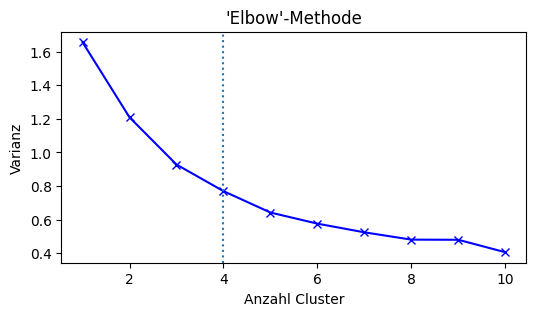

In [250]:
distortions = []
mapping1 = {}
K = range(1, 11)

for k in K:
	kmeanModel = KMeans(n_clusters=k, init = "random").fit(scaled_x)

	distortions.append(sum(min(cdist(scaled_x, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / scaled_x.shape[0])
	
	mapping1[k] = sum(min(cdist(scaled_x, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / scaled_x.shape[0]

figure(figsize=(6,3))
plot(K, distortions, "bx-")
axvline(x=4, linestyle= ":")
xlabel("Anzahl Cluster")
ylabel("Varianz")
title("'Elbow'-Methode")
show()

In [251]:
# Define 4 Clusters with random starting centers
kmeans2 = KMeans(n_clusters=4, init = "random")

# Prediction via K-Means
y_kmeans2 = kmeans2.fit_predict(scaled_x)

# Predicted allocation of datapoints to estimated clusters
y_kmeans2

array([3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 0, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 0, 0, 3, 3, 1, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 0, 1, 3, 3,
       3, 1, 1, 3, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 0, 3, 0, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 2])

Merkmalswerte der Zentren
[[ 0.39287949  0.24461396  0.15230583  2.22797471  0.30158505]
 [ 0.06444105  0.94378613  1.42443269  0.14819741  0.12538634]
 [ 3.2709958   2.92766311  2.32016246  2.19916582  3.99290895]
 [-0.29839364 -0.4267248  -0.4657173  -0.49789211 -0.3483916 ]]


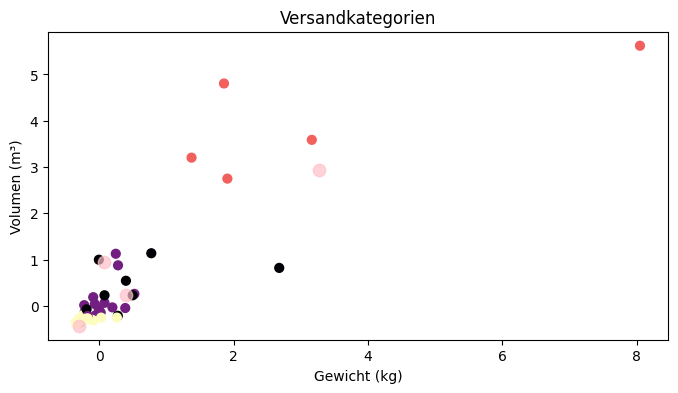

In [252]:
# Visualize allocation of datapoints
figure(figsize=(8,4)) 
scatter(scaled_weight, scaled_volume, c=y_kmeans2, s=40, cmap='magma')

# Visualize Cluster Centers
centers = kmeans2.cluster_centers_
scatter(centers[:,0], centers[:,1], c='pink', s=80, alpha=0.7)

title('Versandkategorien')
xlabel('Gewicht (kg)')
ylabel('Volumen (m³)')

#Print coordinates of Cluster Centers
print('Merkmalswerte der Zentren')
print(centers)

In [253]:
# Define 4 Clusters based on k-means++ for selection of starting centers
kmeans3 = KMeans(n_clusters=4, init="k-means++")

# Prediction via K-Means
y_kmeans3 = kmeans3.fit_predict(scaled_x)

# Predicted allocation of datapoints to estimated clusters
y_kmeans3

array([0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 1, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 3, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 3, 0, 0,
       0, 3, 3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 2])

Merkmalswerte der Zentren
[[-0.29839364 -0.4267248  -0.4657173  -0.49789211 -0.3483916 ]
 [ 0.39287949  0.24461396  0.15230583  2.22797471  0.30158505]
 [ 3.2709958   2.92766311  2.32016246  2.19916582  3.99290895]
 [ 0.06444105  0.94378613  1.42443269  0.14819741  0.12538634]]


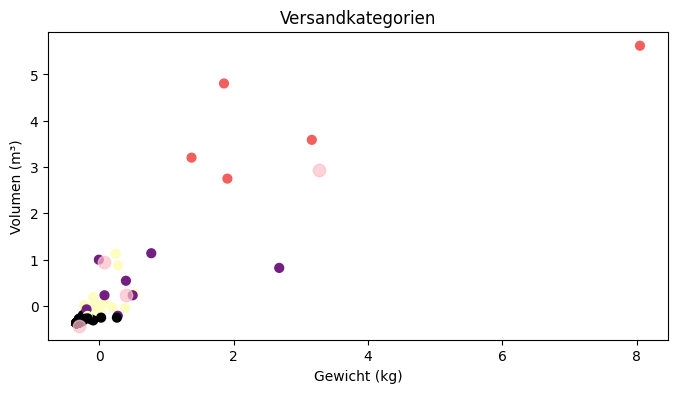

In [254]:
# Visualize allocation of datapoints
figure(figsize=(8,4)) 
scatter(scaled_weight, scaled_volume, c=y_kmeans3, s=40, cmap='magma')

# Visualize Cluster Centers
centers = kmeans3.cluster_centers_
scatter(centers[:,0], centers[:,1], c='pink', s=80, alpha=0.7)

title('Versandkategorien')
xlabel('Gewicht (kg)')
ylabel('Volumen (m³)')

#Print coordinates of Cluster Centers
print('Merkmalswerte der Zentren')
print(centers)

# Hierachical

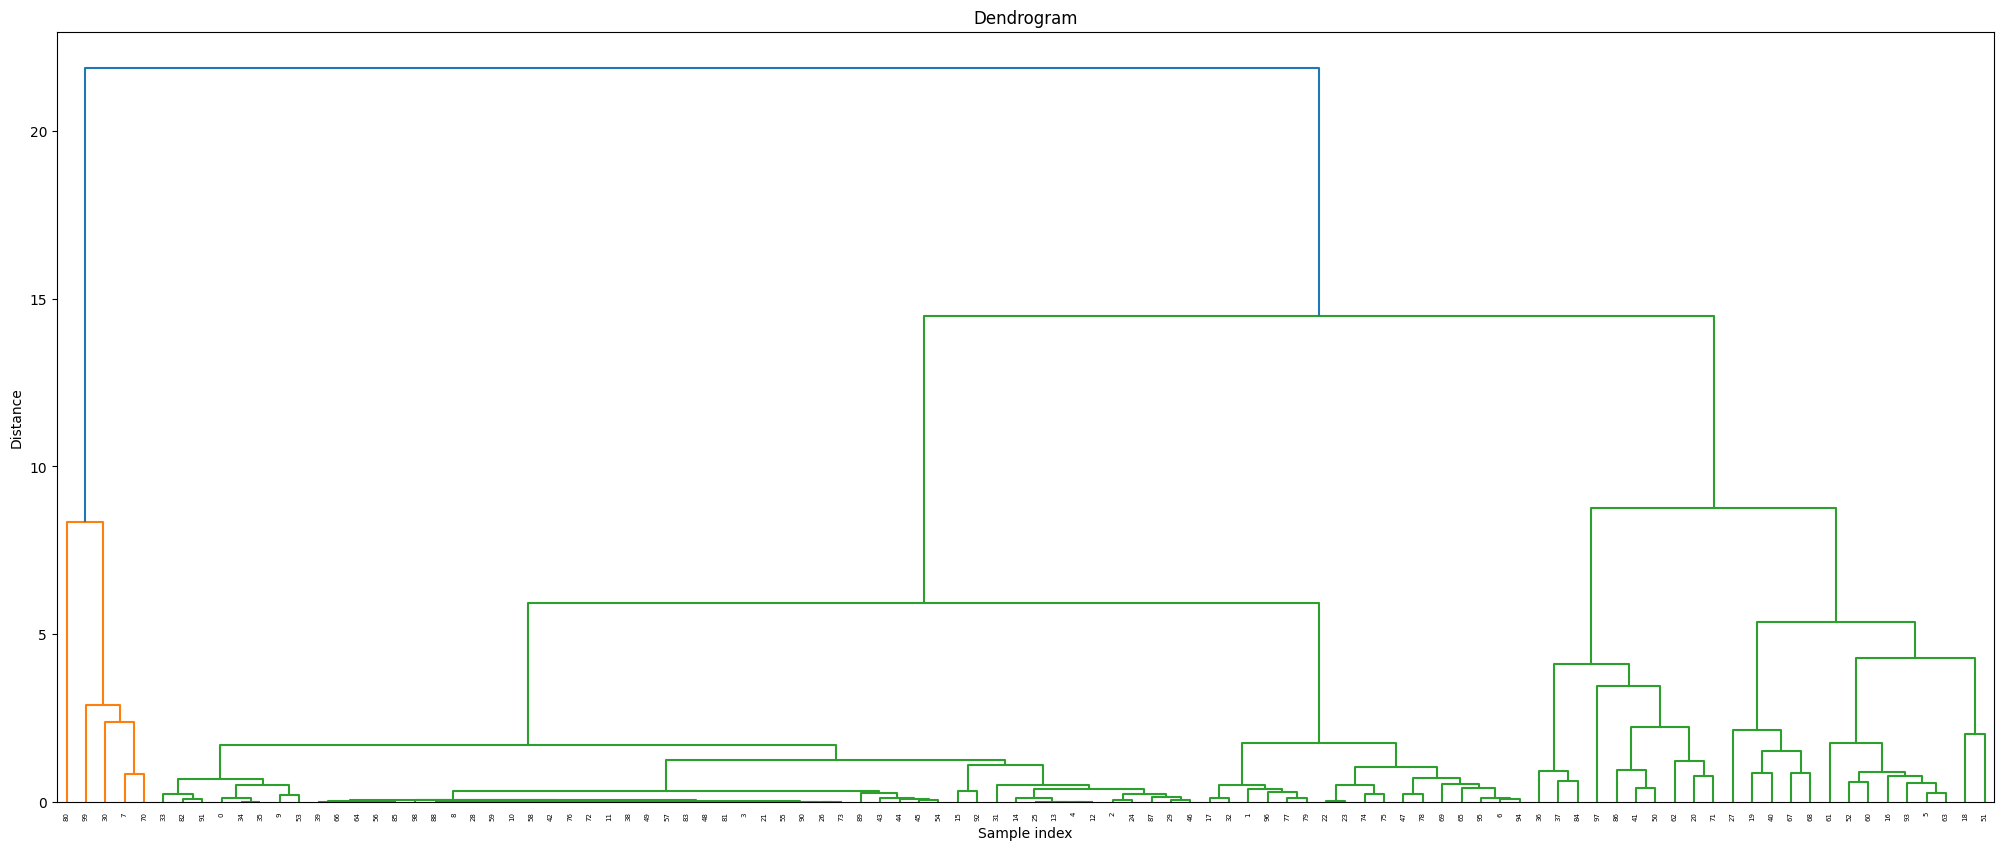

In [255]:
# Plot dendrogram
figure(figsize=(25, 10))
title("Dendrogram")
xlabel("Sample index")
ylabel("Distance")
dend = dendrogram(linkage(scaled_x, method="ward"))

In [256]:
# Build agglomerative clusters and compare by affinity, linkage method and by amount of clusters (through silhouette score)
scores = []
for i in range(2, 10):
    y_cluster_euc_war = AgglomerativeClustering(n_clusters=i, affinity="euclidean", linkage="ward").fit_predict(scaled_x)

    y_cluster_l1_com = AgglomerativeClustering(n_clusters=i, affinity="l1", linkage="complete").fit_predict(scaled_x)
    y_cluster_l1_avg = AgglomerativeClustering(n_clusters=i, affinity="l1", linkage="average").fit_predict(scaled_x)
    y_cluster_l1_sin = AgglomerativeClustering(n_clusters=i, affinity="l1", linkage="single").fit_predict(scaled_x)

    y_cluster_l2_com = AgglomerativeClustering(n_clusters=i, affinity="l2", linkage="complete").fit_predict(scaled_x)
    y_cluster_l2_avg = AgglomerativeClustering(n_clusters=i, affinity="l2", linkage="average").fit_predict(scaled_x)
    y_cluster_l2_sin = AgglomerativeClustering(n_clusters=i, affinity="l2", linkage="single").fit_predict(scaled_x)

    y_cluster_man_com = AgglomerativeClustering(n_clusters=i, affinity="manhattan", linkage="complete").fit_predict(scaled_x)
    y_cluster_man_avg = AgglomerativeClustering(n_clusters=i, affinity="manhattan", linkage="average").fit_predict(scaled_x)
    y_cluster_man_sin = AgglomerativeClustering(n_clusters=i, affinity="manhattan", linkage="single").fit_predict(scaled_x)

    y_cluster_cos_com = AgglomerativeClustering(n_clusters=i, affinity="cosine", linkage="complete").fit_predict(scaled_x)
    y_cluster_cos_avg = AgglomerativeClustering(n_clusters=i, affinity="cosine", linkage="average").fit_predict(scaled_x)
    y_cluster_cos_sin = AgglomerativeClustering(n_clusters=i, affinity="cosine", linkage="single").fit_predict(scaled_x)

    silhouette_scores = []
    silhouette_scores.append(silhouette_score(scaled_x, y_cluster_euc_war, metric="euclidean"))
    
    silhouette_scores.append(silhouette_score(scaled_x, y_cluster_l1_com, metric="l1"))
    silhouette_scores.append(silhouette_score(scaled_x, y_cluster_l1_avg, metric="l1"))
    silhouette_scores.append(silhouette_score(scaled_x, y_cluster_l1_sin, metric="l1"))

    silhouette_scores.append(silhouette_score(scaled_x, y_cluster_l2_com, metric="l2"))
    silhouette_scores.append(silhouette_score(scaled_x, y_cluster_l2_avg, metric="l2"))
    silhouette_scores.append(silhouette_score(scaled_x, y_cluster_l2_sin, metric="l2"))

    silhouette_scores.append(silhouette_score(scaled_x, y_cluster_man_com, metric="manhattan"))
    silhouette_scores.append(silhouette_score(scaled_x, y_cluster_man_avg, metric="manhattan"))
    silhouette_scores.append(silhouette_score(scaled_x, y_cluster_man_sin, metric="manhattan"))

    silhouette_scores.append(silhouette_score(scaled_x, y_cluster_cos_com, metric="cosine"))
    silhouette_scores.append(silhouette_score(scaled_x, y_cluster_cos_avg, metric="cosine"))
    silhouette_scores.append(silhouette_score(scaled_x, y_cluster_cos_sin, metric="cosine"))

    scores.append(silhouette_scores)

scores = asarray(scores)
scores

array([[0.74547525, 0.78450297, 0.78450297, 0.80066302, 0.74547525,
        0.79342634, 0.79342634, 0.78450297, 0.78450297, 0.80066302,
        0.71619154, 0.70197367, 0.10575244],
       [0.59145112, 0.75033239, 0.75033239, 0.75033239, 0.7061803 ,
        0.7061803 , 0.7061803 , 0.75033239, 0.75033239, 0.75033239,
        0.65817455, 0.65466119, 0.36618366],
       [0.61713232, 0.60982522, 0.62938467, 0.73188118, 0.56671092,
        0.60746644, 0.68329368, 0.60982522, 0.62938467, 0.73188118,
        0.68231783, 0.71194073, 0.4160971 ],
       [0.62308684, 0.59713643, 0.61844573, 0.57055472, 0.54949248,
        0.5972812 , 0.57867475, 0.59713643, 0.61844573, 0.57055472,
        0.68141835, 0.73423376, 0.62354932],
       [0.55796575, 0.57740648, 0.59990554, 0.5472897 , 0.52405576,
        0.5761406 , 0.57879276, 0.57740648, 0.59990554, 0.5472897 ,
        0.70509526, 0.77490423, 0.67358242],
       [0.58295022, 0.56924973, 0.59589363, 0.54428475, 0.59841267,
        0.56753491, 0.54066

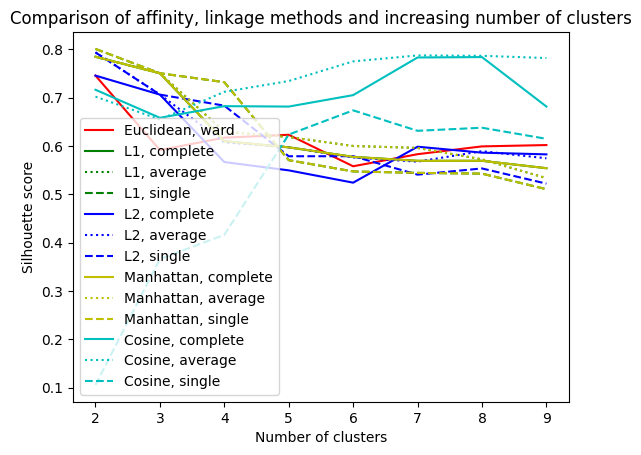

In [257]:
# Plot comparison
plot_x = [i for i in range(2, 10)]
plot(plot_x, scores[:, :1].flatten(), color="r", linestyle="solid", label="Euclidean, ward")

plot(plot_x, scores[:, 1:2].flatten(), color="g", linestyle="solid", label="L1, complete")
plot(plot_x, scores[:, 2:3].flatten(), color="g", linestyle="dotted", label="L1, average")
plot(plot_x, scores[:, 3:4].flatten(), color="g", linestyle="dashed", label="L1, single")

plot(plot_x, scores[:, 4:5].flatten(), color="b", linestyle="solid", label="L2, complete")
plot(plot_x, scores[:, 5:6].flatten(), color="b", linestyle="dotted", label="L2, average")
plot(plot_x, scores[:, 6:7].flatten(), color="b", linestyle="dashed", label="L2, single")

plot(plot_x, scores[:, 7:8].flatten(), color="y", linestyle="solid", label="Manhattan, complete")
plot(plot_x, scores[:, 8:9].flatten(), color="y", linestyle="dotted", label="Manhattan, average")
plot(plot_x, scores[:, 9:10].flatten(), color="y", linestyle="dashed", label="Manhattan, single")

plot(plot_x, scores[:, 10:11].flatten(), color="c", linestyle="solid", label="Cosine, complete")
plot(plot_x, scores[:, 11:12].flatten(), color="c", linestyle="dotted", label="Cosine, average")
plot(plot_x, scores[:, 12:].flatten(), color="c", linestyle="dashed", label="Cosine, single")
  
xlabel("Number of clusters")
ylabel("Silhouette score")
title("Comparison of affinity, linkage methods and increasing number of clusters")
  
# Adding legend
legend()

Text(0, 0.5, 'Volume (m³)')

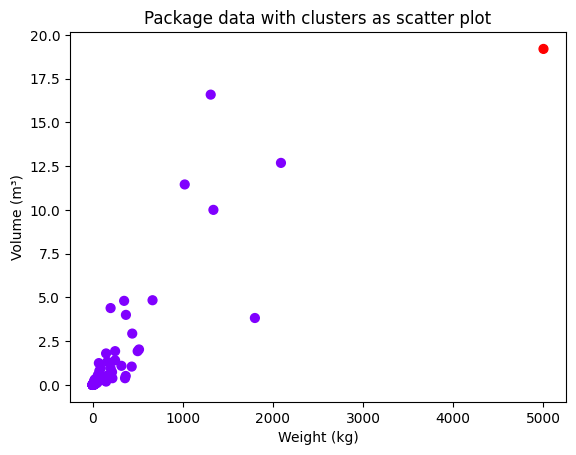

In [258]:
# Plot final cluster decision
cluster_l1_sin = AgglomerativeClustering(n_clusters=2, affinity="l1", linkage="single")
y_cluster_l1_sin = cluster_l1_sin.fit_predict(scaled_x)
scatter(x["Gross Weight (kg)"].to_numpy(), x["Volume (m³)"].to_numpy(), c=y_cluster_l1_sin, s=40, cmap="rainbow")
title("Package data with clusters as scatter plot")
xlabel("Weight (kg)")
ylabel("Volume (m³)")